# Run Learning Diagnostics

In [2]:
import os
import sys
import numpy
import math
import caffe

from pprint import pprint
from pylab import *
%matplotlib inline

caffe.set_device(0)
caffe.set_mode_gpu()

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
## Set up the network
from caffe import layers as L
from caffe import params as P

# define the network here:
def lenet(lmdb, mean_file, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param={
                                'scale': 1./255,
                                'mean_file': mean_file
                            }, ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=7, stride=3, num_output=20, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.conv1)
    n.pool1 = L.Pooling(n.relu1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.norm1 = L.LRN(n.pool1, alpha=0.0001, beta=0.75)
    
    n.conv2 = L.Convolution(n.norm1, kernel_size=5, pad=2, num_output=40, weight_filler=dict(type='xavier'))
    n.relu2 = L.ReLU(n.conv2)
    n.pool2 = L.Pooling(n.relu2, kernel_size=2, stride=1, pool=P.Pooling.MAX)
    n.norm2 = L.LRN(n.pool2, alpha=0.0001, beta=0.75)

    n.conv3 = L.Convolution(n.norm2, kernel_size=3, pad=1, num_output=80, weight_filler=dict(type='xavier'))
    n.relu3 = L.ReLU(n.conv3)
    n.pool3 = L.Pooling(n.relu3, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.norm3 = L.LRN(n.pool3, alpha=0.0001, beta=0.75)

    n.ip1 = L.InnerProduct(n.norm3, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    
    n.ip2 = L.InnerProduct(n.relu1, num_output=2, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    

In [33]:
def configure_solver (total_size):
    solver_config = """# Generated from python.
    # Train Set
    # Size: 11997
    # Batch: 512
    # Epoch = 24 iterations
    #
    # Test Set
    # Size: 3290
    # Batch: 100
    # Epoch = 33 iterations
    #
    # Training net
    train_net: "temp/lenet_auto_train.prototxt"
    # Test net
    test_net: "temp/lenet_auto_test.prototxt"
    test_iter: 33
    # Run testing every ___ iterations:
    test_interval: 1000
    # The base learning rate, momentum and the weight decay of the network.
    base_lr: 0.01
    momentum: 0.9
    weight_decay: 0.005
    # The learning rate policy
    lr_policy: "step"
    gamma: 0.1
    # ~ 20 epochs rule of thumb from Karpathy
    stepsize: %(twenty_epochs)i
    # Display ~ every 5 epochs
    display: 100
    # The maximum number of iterations
    max_iter: 5000
    # solver mode: CPU or GPU
    solver_mode: GPU""" % {
        'twenty_epochs': int(total_size * 20.0 / 512)
    }

    with open('temp/autosolver.prototxt', 'w') as f:
        f.write(solver_config)


In [49]:
import sklearn.metrics as metrics
def run_test(net, iterations):
    y_true = []
    y_pred = []
    loss = 0.0
    for test_it in range(iterations):
        net.forward()
        y_pred.extend(net.blobs['ip2'].data.argmax(1))
        y_true.extend(net.blobs['label'].data)
        loss = loss + net.blobs['loss'].data
    
    accuracy_score = metrics.accuracy_score(y_true, y_pred)
    precision_score = metrics.precision_score(y_true, y_pred)
    recall_score = metrics.recall_score(y_true, y_pred)
    loss = loss / iterations
    
    return loss, accuracy_score, precision_score, recall_score

In [53]:
training_sets = [1000 , 2000, 4000, 6000, 8000, 10000]
results = {}
for s in training_sets:
    configure_solver(s)
    
    with open('temp/lenet_auto_train.prototxt', 'w') as f:
        f.write('name: "LeNet"\n')
        prefix = 'temp/train-' + str(s) + '-lmdb'
        f.write(str(lenet(prefix, 'temp/learnsat_mean.binaryproto', 512)))

    with open('temp/lenet_auto_test.prototxt', 'w') as f:
        f.write(str(lenet('temp/learnsat_val_lmdb', 'temp/learnsat_mean.binaryproto', 100)))
        
    solver = caffe.SGDSolver('temp/autosolver.prototxt')
    
    results[s] = {}
    
    epochs = 100
    niter = int(epochs * s / 512.0 + 1)
    test_interval = niter - 1 # just test once at the beginning and once at the end
    ntest = 1 + int(np.ceil(float(niter-1) / test_interval))
    assert(ntest == 2)
    # losses will also be stored in the log
    train_loss = zeros(ntest)
    test_loss = zeros(ntest)
    train_acc = zeros(ntest)
    test_acc = zeros(ntest)
    test_precision = zeros(ntest)
    test_recall = zeros(ntest)

    print 'Training on ' + str(s) + ' inputs for ' + str(niter) + ' iterations.'
        
    # the main solver loop
    for it in range(niter):
        solver.step(1)  # SGD by Caffe
        # run a full test every so often
        if it % test_interval == 0:
            print 'Iteration', it, 'testing...'
            index = it // test_interval
            test_loss[index], test_acc[index], test_precision[index], test_recall[index] = run_test(solver.test_nets[0], 33)
            train_loss[index], train_acc[index], _, _ = run_test(solver.net, np.ceil(s / 512.))
        
    # run a final test at the end
    results[s] = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'test_loss': test_loss,
        'test_acc': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall
    }

print('Done')

Training on 1000 inputs for 196 iterations.
Iteration 0 testing...
Iteration 195 testing...
Training on 2000 inputs for 391 iterations.
Iteration 0 testing...
Iteration 390 testing...
Training on 4000 inputs for 782 iterations.
Iteration 0 testing...
Iteration 781 testing...
Training on 6000 inputs for 1172 iterations.
Iteration 0 testing...
Iteration 1171 testing...
Training on 8000 inputs for 1563 iterations.
Iteration 0 testing...
Iteration 1562 testing...
Training on 10000 inputs for 1954 iterations.
Iteration 0 testing...
Iteration 1953 testing...
Done


[1000, 2000, 4000, 6000, 8000, 10000]
[0.61575757575757573, 0.64848484848484844, 0.72636363636363632, 0.76757575757575758, 0.79212121212121211, 0.80030303030303029]
[0.6484375, 0.64973958333333337, 0.7494419642857143, 0.79421164772727271, 0.80989583333333337, 0.81907894736842102]


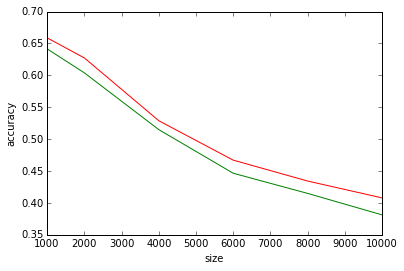

In [55]:
size = training_sets
test_loss = [results[r]['test_loss'][1] for r in training_sets]
train_loss = [results[r]['train_loss'][1] for r in training_sets]
test_acc = [results[r]['test_acc'][1] for r in training_sets]
train_acc = [results[r]['train_acc'][1] for r in training_sets]
precision = [results[r]['test_precision'][1] for r in training_sets]
recall = [results[r]['test_recall'][1] for r in training_sets]
print(size)
print(test_acc)
print(train_acc)
fig, ax1 = subplots()
ax1.plot(size, test_loss, 'r',
         size, train_loss, 'g')
ax1.set_xlabel('size')
ax1.set_ylabel('accuracy')

In [ ]:
from shutil import copyfile

results_file = 'results/lenet-2.2nd-try'
if os.path.exists(results_file + '_train_loss.npy'):
    print('File exists! NOT saving!')
else:
    numpy.save(results_file + '_train_loss.npy', train_loss)
    numpy.save(results_file + '_train_acc.npy', train_acc)
    numpy.save(results_file + '_test_acc.npy', test_acc)
    fig.savefig(results_file + '_plot.png')
    copyfile('temp/lenet_auto_train.prototxt', results_file + '_train.prototxt')
    copyfile('temp/autosolver.prototxt', results_file + '_solver.prototxt')